Классифицируем ЭКГ. Требуется разработать и обучить три модели: обычную рекуррентную сеть, LSTM и GRU. Результаты сравнить, так же как и в прошлой работе - вывести графики с динамикой обучения, дать объяснение сравнительного превосходства той или иной архитектуры. Сравнить скорости обучения разных архитектур.


# Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout, LSTM, SimpleRNN, GRU
from keras.optimizers import Adam
from keras import  backend as K
from keras.utils import to_categorical, plot_model

import tensorflow as tf

print(tf.__version__)

2.11.0


# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = './drive/MyDrive/data/'

train_data = pd.read_csv(path + 'mitbih_train.csv').sample(frac=1, random_state=42).values
test_data = pd.read_csv(path + 'mitbih_test.csv').sample(frac=1, random_state=42).values

In [ ]:
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
print(X_train.shape)
print(np.unique(y_train))

(87553, 1, 187)
[0. 1. 2. 3. 4.]


In [ ]:
print(X_test.shape)
print(np.unique(y_test))

(21891, 1, 187)
[0. 1. 2. 3. 4.]


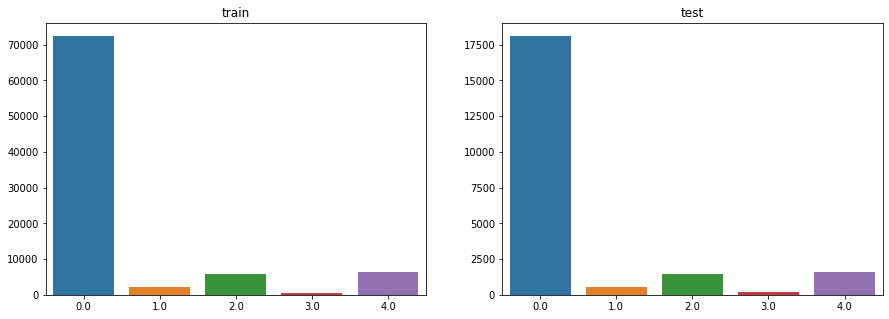

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts, ax=ax[0])
ax[0].title.set_text('train')

unique, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=unique, y=counts, ax=ax[1])
ax[1].title.set_text('test')

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Model Settings

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.995:
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
num_classes

5

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(1, 187)

In [ ]:
batch_size = 128

# SimpleRNN

In [ ]:
model_rnn = Sequential([
    SimpleRNN(64, input_shape= input_shape, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, callbacks=[callbacks])

Epoch 1/20
616/616 [==============================] - 7s 7ms/step - loss: 0.3081 - accuracy: 0.9138 - val_loss: 0.1674 - val_accuracy: 0.9533
Epoch 2/20
616/616 [==============================] - 4s 6ms/step - loss: 0.1800 - accuracy: 0.9505 - val_loss: 0.1314 - val_accuracy: 0.9638
Epoch 3/20
616/616 [==============================] - 5s 8ms/step - loss: 0.1533 - accuracy: 0.9572 - val_loss: 0.1228 - val_accuracy: 0.9659
Epoch 4/20
616/616 [==============================] - 5s 9ms/step - loss: 0.1401 - accuracy: 0.9612 - val_loss: 0.1143 - val_accuracy: 0.9686
Epoch 5/20
616/616 [==============================] - 4s 6ms/step - loss: 0.1297 - accuracy: 0.9638 - val_loss: 0.1066 - val_accuracy: 0.9685
Epoch 6/20
616/616 [==============================] - 4s 7ms/step - loss: 0.1224 - accuracy: 0.9659 - val_loss: 0.1016 - val_accuracy: 0.9718
Epoch 7/20
616/616 [==============================] - 5s 8ms/step - loss: 0.1182 - accuracy: 0.9671 - val_loss: 0.0982 - val_accuracy: 0.9721
Epoch 

In [ ]:
loss_rnn, acc_rnn = model_rnn.evaluate(X_test, y_test)
print("\nTest accuracy: %.2f%%" % (100.0 * acc_rnn))

685/685 [==============================] - 2s 3ms/step - loss: 0.0875 - accuracy: 0.9767

Test accuracy: 97.67%


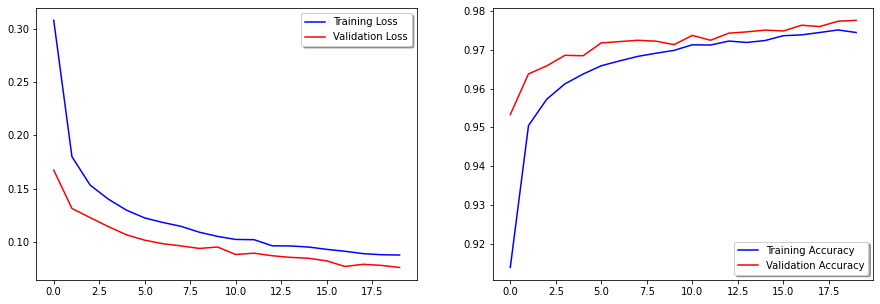

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_rnn.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_rnn.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_rnn.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_rnn.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Predict the values from the testing dataset
Y_pred = model_rnn.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)


685/685 [==============================] - 3s 3ms/step


<Axes: >

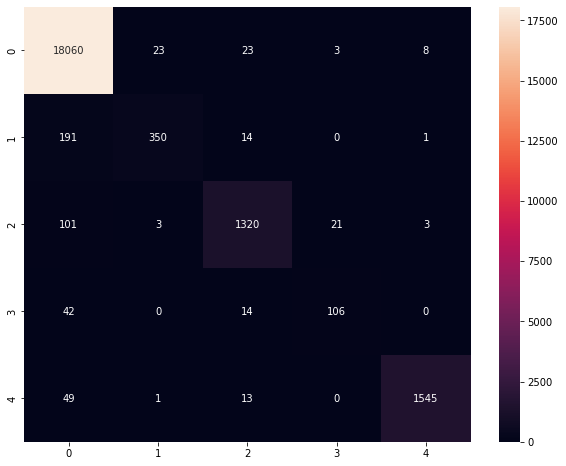

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# LSTM

In [ ]:
model_lstm = Sequential([
    LSTM(64, input_shape=input_shape),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, callbacks=[callbacks])

Epoch 1/20
616/616 [==============================] - 12s 15ms/step - loss: 0.2706 - accuracy: 0.9279 - val_loss: 0.1431 - val_accuracy: 0.9605
Epoch 2/20
616/616 [==============================] - 8s 13ms/step - loss: 0.1430 - accuracy: 0.9611 - val_loss: 0.1125 - val_accuracy: 0.9685
Epoch 3/20
616/616 [==============================] - 8s 13ms/step - loss: 0.1191 - accuracy: 0.9661 - val_loss: 0.0970 - val_accuracy: 0.9733
Epoch 4/20
616/616 [==============================] - 7s 11ms/step - loss: 0.1047 - accuracy: 0.9703 - val_loss: 0.0901 - val_accuracy: 0.9735
Epoch 5/20
616/616 [==============================] - 8s 12ms/step - loss: 0.0965 - accuracy: 0.9723 - val_loss: 0.0848 - val_accuracy: 0.9733
Epoch 6/20
616/616 [==============================] - 5s 9ms/step - loss: 0.0893 - accuracy: 0.9742 - val_loss: 0.0853 - val_accuracy: 0.9737
Epoch 7/20
616/616 [==============================] - 7s 11ms/step - loss: 0.0843 - accuracy: 0.9755 - val_loss: 0.0783 - val_accuracy: 0.9753

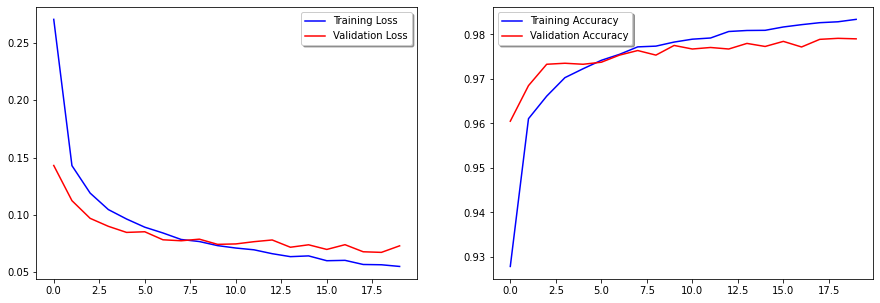

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_lstm.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_lstm.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_lstm.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_lstm.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Predict the values from the testing dataset
Y_pred = model_lstm.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)


685/685 [==============================] - 2s 3ms/step


In [ ]:
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print("\nTest accuracy: %.2f%%" % (100.0 * acc_lstm))

685/685 [==============================] - 2s 3ms/step - loss: 0.0858 - accuracy: 0.9783

Test accuracy: 97.83%


<Axes: >

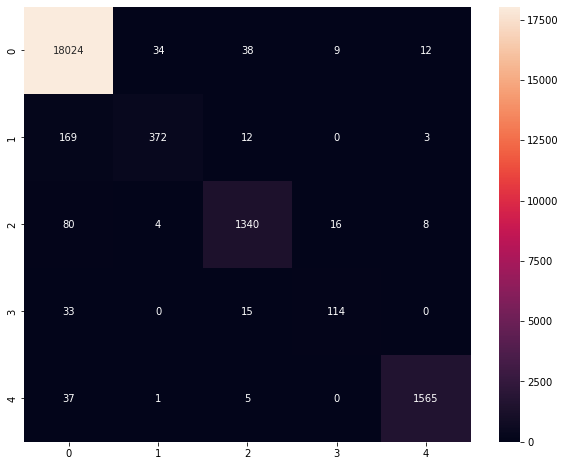

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# GRU

In [ ]:
model_gru = Sequential([
    GRU(64, input_shape=input_shape),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, callbacks=[callbacks])

Epoch 1/20
616/616 [==============================] - 15s 13ms/step - loss: 0.2721 - accuracy: 0.9245 - val_loss: 0.1518 - val_accuracy: 0.9593
Epoch 2/20
616/616 [==============================] - 9s 15ms/step - loss: 0.1513 - accuracy: 0.9587 - val_loss: 0.1149 - val_accuracy: 0.9677
Epoch 3/20
616/616 [==============================] - 6s 9ms/step - loss: 0.1257 - accuracy: 0.9654 - val_loss: 0.1058 - val_accuracy: 0.9695
Epoch 4/20
616/616 [==============================] - 9s 15ms/step - loss: 0.1126 - accuracy: 0.9688 - val_loss: 0.0955 - val_accuracy: 0.9711
Epoch 5/20
616/616 [==============================] - 5s 9ms/step - loss: 0.1028 - accuracy: 0.9710 - val_loss: 0.0869 - val_accuracy: 0.9738
Epoch 6/20
616/616 [==============================] - 10s 16ms/step - loss: 0.0969 - accuracy: 0.9722 - val_loss: 0.0890 - val_accuracy: 0.9738
Epoch 7/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0928 - accuracy: 0.9736 - val_loss: 0.0835 - val_accuracy: 0.9745


In [ ]:
loss_gru, acc_gru = model_gru.evaluate(X_test, y_test)
print("\nTest accuracy: %.2f%%" % (100.0 * acc_gru))

685/685 [==============================] - 2s 3ms/step - loss: 0.0778 - accuracy: 0.9789

Test accuracy: 97.89%


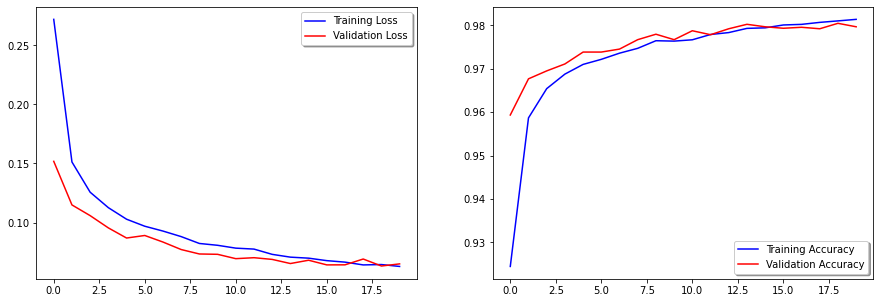

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_gru.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_gru.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_gru.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_gru.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Predict the values from the testing dataset
Y_pred = model_gru.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)


685/685 [==============================] - 2s 2ms/step


<Axes: >

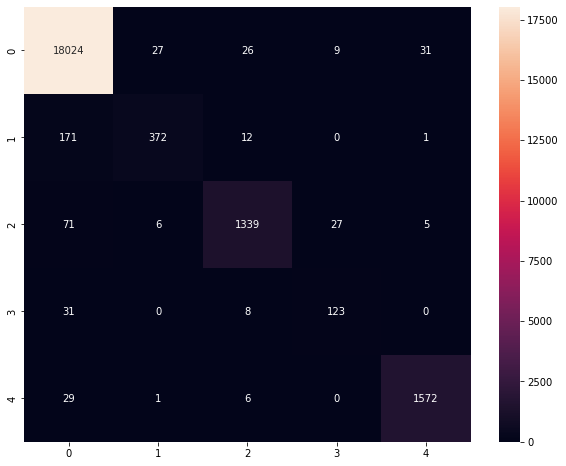

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# Results

In [ ]:
print("\nTest accuracy RNN: %.2f%%" % (100.0 * acc_rnn))
print("\nTest accuracy LSTM: %.2f%%" % (100.0 * acc_lstm))
print("\nTest accuracy GRU: %.2f%%" % (100.0 * acc_gru))


Test accuracy RNN: 97.67%

Test accuracy LSTM: 97.83%

Test accuracy GRU: 97.89%


Было выявлено, что LSTM и GRU показывают себя лучше всего и отличаются друг от друга на несколько сотых процента в зависимости от random_state при перемешивании датасета.

Датасет был перемешан из-за того, что изначальный датасет был отсортирован по классу.

В любом случае, SimpleRNN показывала себя хуже всего.  

Также, было выявлено, что данный датасет имеет большое количество сэмплов с классом 0 и крайне малое количество с классами 1-4, из-за чего все модели плохо предсказывают остальные классы (это можно увидеть из confusion матрицы)